# Breast Cancer Diagnostic Model

In [3]:
# Import the libraries
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style="darkgrid")

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn.model_selection import train_test_split


In [4]:
#import breast cancer dataset
bc_data = pd.read_csv('Breast_cancer_data.csv')

#shuffle data rows randomly
indices = np.arange(bc_data.shape[0])
shuffled_indices = np.random.permutation(indices)
bc_data = bc_data.reindex(shuffled_indices)

#display shuffled data
display(bc_data)

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
421,14.690,13.98,98.22,656.1,0.10310,1
301,12.460,19.89,80.43,471.3,0.08451,1
0,17.990,10.38,122.80,1001.0,0.11840,0
358,8.878,15.49,56.74,241.0,0.08293,1
568,7.760,24.54,47.92,181.0,0.05263,1
...,...,...,...,...,...,...
20,13.080,15.71,85.63,520.0,0.10750,1
196,13.770,22.29,90.63,588.9,0.12000,0
223,15.750,20.25,102.60,761.3,0.10250,0
460,17.080,27.15,111.20,930.9,0.09898,0


In [5]:
#split dataframe between train and test
train, test = train_test_split(bc_data, test_size=0.2)

In [6]:
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (455, 6)
test shape:  (114, 6)


In [7]:
# Separate data and labels in the training and test sets
train_labels = train['diagnosis']  # Extract the diagnosis labels for the training set
train = train[['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness']]  # Extract the corresponding features for the training set

test_labels = test['diagnosis']  # Extract the diagnosis labels for the test set
test = test[['mean_radius', 'mean_texture', 'mean_perimeter', 'mean_area', 'mean_smoothness']]  # Extract the corresponding features for the test set



pairwise plot:



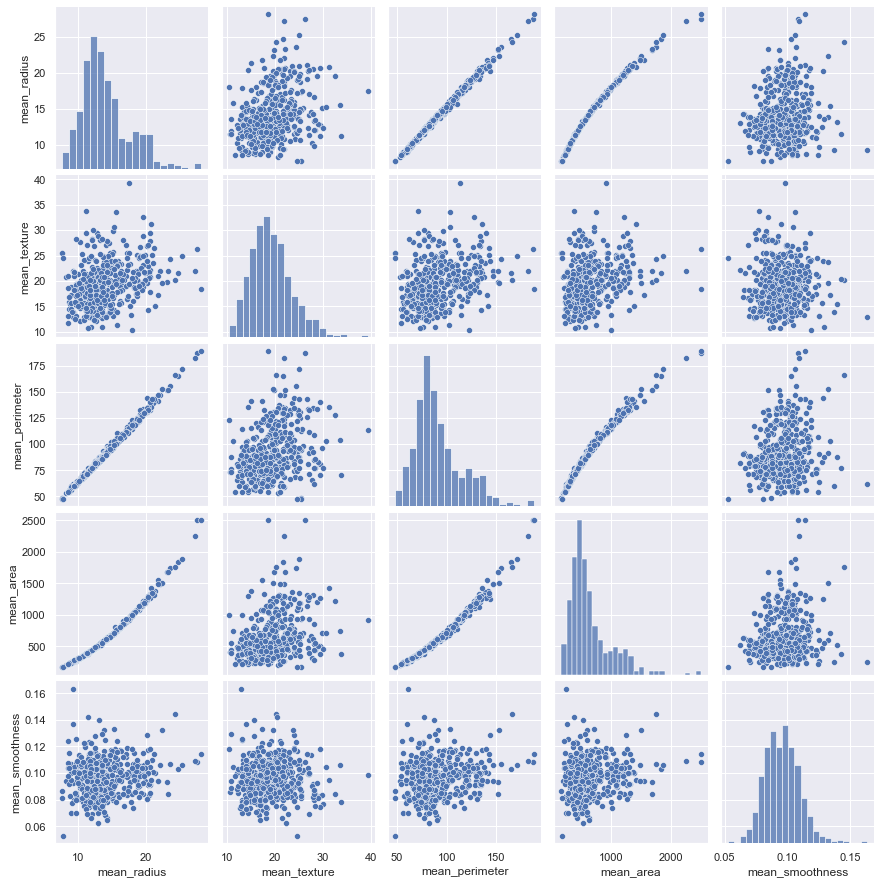

In [8]:
# Generate pairwise plot to examine relationships between features
sns.pairplot(train)

# Display the pairwise plot
print('\npairwise plot:\n')
plt.show()

In [7]:
#mean perimeter and mean area removed from test data frame as closely related to radius
test = test[['mean_radius', 'mean_texture', 'mean_smoothness']]
test = test[['mean_radius', 'mean_texture', 'mean_smoothness']]

In [9]:
#checking features value distribution
display(test.describe())

#normalizing data so all features in same scale
norm_train = (train - train.mean())/ train.std()


#normalizing test data using mean and std from train data
norm_test = (test - train.mean())/ train.std()

print('\nnormalized training:')
display(norm_train.describe())
print('\nnormalized test:')
display(norm_test.describe())



,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
count,114.000000,114.000000,114.000000,114.000000,114.000000
mean,14.478491,19.297018,94.405965,689.191228,0.098576
std,3.661050,4.241218,25.236210,363.880718,0.013617
min,6.981000,9.710000,43.790000,143.500000,0.069950
25%,11.770000,16.150000,75.425000,427.000000,0.088778
50%,13.650000,19.030000,87.630000,573.200000,0.097815
75%,16.967500,21.835000,110.000000,894.525000,0.108875
max,25.730000,30.720000,174.200000,2010.000000,0.127300



normalized training:


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
count,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02,4.550000e+02
mean,-9.285536e-16,5.926395e-15,3.447715e-15,7.941145e-16,4.010101e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.820310e+00,-2.061747e+00,-1.806301e+00,-1.364638e+00,-3.054676e+00
25%,-6.750711e-01,-7.204707e-01,-6.796098e-01,-6.510556e-01,-7.400577e-01
50%,-2.177212e-01,-1.036456e-01,-2.315532e-01,-2.898913e-01,-6.261696e-02
75%,4.704543e-01,5.698857e-01,4.861690e-01,3.259089e-01,6.151775e-01
max,4.034630e+00,4.627276e+00,4.039434e+00,5.318407e+00,4.782411e+00



normalized test:


,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
count,114.000000,114.000000,114.000000,114.000000,114.000000
mean,0.125934,0.002133,0.126724,0.123007,0.196077
std,1.049769,0.981647,1.049397,1.043436,0.963433
min,-2.023895,-2.216821,-1.978038,-1.441775,-1.829269
25%,-0.650698,-0.726257,-0.662561,-0.628832,-0.497205
50%,-0.111627,-0.059669,-0.155041,-0.209601,0.142207
75%,0.839632,0.589559,0.775171,0.711806,0.924713
max,3.352189,2.646029,3.444798,3.910454,2.228300


In [10]:
def build_model(num_features, learning_rate=0.01, optimizer='SGD'):
    """Build a TF logistic regression model using Keras.
    
    Args:
        num_features: The number of input features.
        learning_rate: The desired learning rate for SGD.
        optimizer: The optimizer to use for training.
        
    Returns:
        model: A tf.keras model (graph).
    """
  
    # Set the random seeds to ensure reproducibility
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)

    # Build the model using keras.Sequential
    model = keras.Sequential()

    # Add a dense layer to construct the linear set of parameters for each input feature
    # and apply a sigmoid activation function
    model.add(keras.layers.Dense(
        units=1,                     # Output dimension (for binary classification)
        use_bias=True,               # Use a bias parameter
        input_shape=[num_features],
        activation="sigmoid",         # Apply the sigmoid function
        kernel_initializer=tf.ones_initializer,  # Initialize parameters to 1
        bias_initializer=tf.ones_initializer    # Initialize bias to 1
    ))

    # Set the optimizer based on the specified option
    if optimizer == 'SGD':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'Adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model with binary cross-entropy loss and binary accuracy as the metric
    model.compile(loss='binary_crossentropy', 
                  optimizer=opt, 
                  metrics=[metrics.binary_accuracy])

    return model


In [11]:
# Build the model.
model = build_model(1)

# Make a prediction for five inputs when only one feature is inputted.
print(model.predict(norm_train['mean_radius'][0:5]))

1/1 [==============================] - 0s 121ms/step
[[0.47837782]
 [0.56825846]
 [0.75304097]
 [0.5363648 ]
 [0.6965715 ]]


In [11]:
# train model with only mean raidus 
model = build_model(num_features = 1, learning_rate=0.01)

# Fit the model on non-normalized training data.
history = model.fit(
  x = train[['mean_radius']],   # binary training examples
  y = train_labels,   # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size for SGD
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
display(history)


Epoch 1/5
7/7 [==============================] - 1s 32ms/step - loss: 5.5605 - binary_accuracy: 0.6406 - val_loss: 4.5218 - val_binary_accuracy: 0.6087
Epoch 2/5
7/7 [==============================] - 0s 5ms/step - loss: 2.8328 - binary_accuracy: 0.6406 - val_loss: 1.4854 - val_binary_accuracy: 0.6087
Epoch 3/5
7/7 [==============================] - 0s 5ms/step - loss: 0.8193 - binary_accuracy: 0.6479 - val_loss: 0.6045 - val_binary_accuracy: 0.8043
Epoch 4/5
7/7 [==============================] - 0s 5ms/step - loss: 0.6145 - binary_accuracy: 0.7286 - val_loss: 0.6151 - val_binary_accuracy: 0.6304
Epoch 5/5
7/7 [==============================] - 0s 5ms/step - loss: 0.6155 - binary_accuracy: 0.6797 - val_loss: 0.6007 - val_binary_accuracy: 0.8913


,loss,binary_accuracy,val_loss,val_binary_accuracy
0,5.560514,0.640587,4.521790,0.608696
1,2.832753,0.640587,1.485391,0.608696
2,0.819251,0.647922,0.604531,0.804348
3,0.614543,0.728606,0.615105,0.630435
4,0.615498,0.679707,0.600702,0.891304


In [12]:
# train different features

def plot_loss(model, history):
    """Plot the loss after each training epoch."""
    # Convert the history object into a DataFrame.
    history = pd.DataFrame(history.history)
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(range(len(history)), history['loss'], marker='.', color='black')
    plt.plot(range(len(history)), history['val_loss'], marker='.', color='red')
    plt.legend(['train loss', 'validation loss'])
    plt.show()
    
    # Show the final train loss value and the learned model weights.
    print('Final train loss:', list(history['loss'])[-1])
    print('Final weights:', model.layers[0].get_weights())

In [13]:
#finding optimal learning rate with only single feature

learn_rate = [0.0001, 0.001, 0.01, 0.1, 1]

#iterate over each learning rate to initite a model 
for rate in learn_rate:
    model = build_model(num_features=1, learning_rate= rate)

    history = model.fit(
      # use the normalized features prepared above
      x = norm_train[['mean_radius']],
      y = train_labels,
      validation_split=0.1,
      epochs=150,
      batch_size=32,
      verbose=0)
    
    history = pd.DataFrame(history.history)
    
    print(f"\nLearning rate of {rate}")
    print('Final train loss:', list(history['val_loss'])[-1])


Learning rate of 0.0001
Final train loss: 1.1818161010742188

Learning rate of 0.001
Final train loss: 0.7629863023757935

Learning rate of 0.01
Final train loss: 0.2761932909488678

Learning rate of 0.1
Final train loss: 0.23235775530338287

Learning rate of 1
Final train loss: 0.22991620004177094


In [14]:
#check best learning rate along with better optimizer

learn_rate = [0.0001, 0.001, 0.01, 0.1, 1]

#iterate of each learning rate to initite a model 
for rate in learn_rate:
    model = build_model(num_features=1, learning_rate= rate, optimizer = 'Adam')

    history = model.fit(
      # use the normalized features prepared above
      x = norm_train[['mean_radius']],
      y = train_labels,
      validation_split=0.1,
      epochs=150,
      batch_size=32,
      verbose=0)
    
    history = pd.DataFrame(history.history)
    
    print(f"\nLearning rate of {rate}")
    print('Final train loss:', list(history['val_loss'])[-1])


Learning rate of 0.0001
Final train loss: 1.1182998418807983

Learning rate of 0.001
Final train loss: 0.46856215596199036

Learning rate of 0.01
Final train loss: 0.23346498608589172

Learning rate of 0.1
Final train loss: 0.23037412762641907

Learning rate of 1
Final train loss: 0.23237095773220062



Features: ['mean_radius']


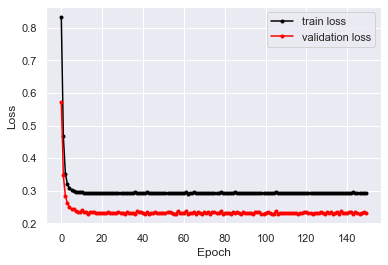

Final train loss: 0.2917950451374054
Final weights: [array([[-3.6907413]], dtype=float32), array([0.7687828], dtype=float32)]


,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.833711,0.599022,0.572451,0.652174
1,0.466514,0.811736,0.347606,0.913043
2,0.352807,0.860636,0.283412,0.934783
3,0.319901,0.880196,0.261890,0.978261
4,0.307426,0.885086,0.250734,0.956522


Test Accuracy: 0.859649121761322
Test rmse: 0.5556658055926773


Features: ['mean_radius', 'mean_texture']


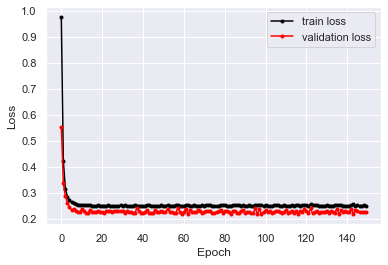

Final train loss: 0.25006258487701416
Final weights: [array([[-3.8726249],
       [-1.0987047]], dtype=float32), array([0.82375], dtype=float32)]


,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.977280,0.520782,0.552069,0.673913
1,0.422455,0.828851,0.335548,0.891304
2,0.314159,0.882641,0.286584,0.913043
3,0.284588,0.889976,0.261614,0.913043
4,0.269727,0.889976,0.244267,0.934783


Test Accuracy: 0.8684210777282715
Test rmse: 0.5459845787148178


Features: ['mean_radius', 'mean_texture', 'mean_smoothness']


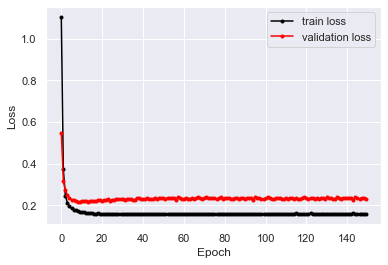

Final train loss: 0.1583622545003891
Final weights: [array([[-5.2014923],
       [-1.8533874],
       [-2.0877428]], dtype=float32), array([1.1455702], dtype=float32)]


,loss,binary_accuracy,val_loss,val_binary_accuracy
0,1.105978,0.481663,0.548445,0.652174
1,0.373356,0.855746,0.316953,0.891304
2,0.247097,0.914425,0.272135,0.913043
3,0.212143,0.919315,0.250421,0.913043
4,0.195737,0.929095,0.235671,0.934783


Test Accuracy: 0.9473684430122375
Test rmse: 0.41139299944362956



In [16]:
# selecting Adam as optimizer along with learning rate of 0.1 based on testing
best_learning_rate = 0.1


def run_experiment(features, learning_rate):
    model = build_model(len(features), learning_rate, optimizer = 'Adam')
    
    history = model.fit(
        x = norm_train[features],
        y = train_labels,
        validation_split=0.1,
        epochs=150,
        batch_size=32,
        verbose=0)
    
    plot_loss(model, history)
    
    
    history = pd.DataFrame(history.history)
    #only display last 5 epochs accuracy
    display(history.head(5))
    
    # Make predictions on test data
    test_loss, test_accuracy = model.evaluate(norm_test[features],
                             test_labels,
                             verbose=0)
    
    print('Test Accuracy:', test_accuracy)
    print('Test rmse:', np.sqrt(test_loss))

    
    
features = ['mean_radius', 'mean_texture', 'mean_smoothness']

#each iteration adds another feature to the run_experiment function
for i in range(len(features)):
    print(f"\nFeatures: {features[:i+1]}")
    run_experiment(features[:i+1], best_learning_rate)
    print()